In [5]:
import pandas as pd

In [6]:
df = pd.read_csv(r"C:\Users\lubac\ACQuA.csv", header=0)
df_french = pd.read_csv(r"C:\Users\lubac\french_df.csv", header=0, index_col=0)
df_russian = pd.read_csv(r"C:\Users\lubac\russian_df.csv", header=0, index_col=0)

In [7]:
df_en_fr_ru = pd.concat([df, df_french, df_russian], ignore_index=True)
df_en_fr_ru = df_en_fr_ru.drop(columns=['id',
                      'domain',
                      'it_1_confidence',
                      'it_2_confidence',
                      'better_count',
                      'worse_count',
                      'none_count',
                      'most_frequent_count',
                      'it_1_judgments', 
                      'it_2_judgments', 
                      'sentence_html', 
                      'judgments', 
                      'confidence', 
                      'dconfidence'])

df_en_fr_ru = df_en_fr_ru.dropna()

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask
#Sentences we want sentence embeddings for
sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?',
             'bonjour, mon nom est Paul']
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")
#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)
#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def embeddings(sentences):
  encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
  with torch.no_grad():
    model_output = model(**encoded_input)
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  return sentence_embeddings

In [13]:
from tqdm import tqdm

objects_a, objects_b, sentences, labels = df_en_fr_ru.object_a.to_list(), df_en_fr_ru.object_b.to_list(), df_en_fr_ru.sentence.to_list(), df_en_fr_ru.most_frequent_label.to_list()

label_d = {'WORSE': 0, 'BETTER': 1, 'NONE': 2}

prepared = []
labels_new = []

for i in tqdm(range(len(objects_a))):
  text = 'OBJECT1 ' + objects_a[i] + ' OBJECT2 ' + objects_b[i] + ' SENTENCE ' + sentences[i]
  prepared.append(embeddings(text)[0].numpy())
  labels_new.append(label_d[labels[i]])

100%|██████████| 21554/21554 [19:21<00:00, 18.56it/s]


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(prepared, labels_new, test_size=0.2, random_state=42)

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [17]:
from sklearn.metrics import f1_score

In [18]:
classifiers = [('Logistic Regression', LogisticRegression()),
               ('AdaBoost', AdaBoostClassifier()), ('SVM (linear)', LinearSVC()),
               ('Decision Tree', DecisionTreeClassifier()),
               ('SGD Classifier', SGDClassifier()), ('Random Forest', RandomForestClassifier()), ('Extra Trees', ExtraTreesClassifier()), ('k-Neighbors', KNeighborsClassifier()),
               ('SVM (radial basis function)', SVC(kernel='rbf')), ('SVM (polynomial)', SVC(kernel='poly')), ('SVM (sigmoid)', SVC(kernel='sigmoid')),
               #('Multinomial NB', MultinomialNB()), 
               ('Majority Class Baseline', DummyClassifier(strategy='most_frequent')), ('XGBoost', XGBClassifier(n_jobs=8, n_estimators=1000))
               ]

results_embeddings = []
for name, classifier in classifiers:
    fitted = classifier.fit(X_train, y_train)
    predicted = fitted.predict(X_test)
    print(name)
    f1 = f1_score(y_test, predicted, average='weighted')
    print(f1)
    print(classification_report(y_test, predicted, labels = [0, 1, 2], target_names=['WORSE', 'BETTER', 'NONE']))
    results_embeddings.append([name, f1])

C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
0.6702331632145511
              precision    recall  f1-score   support

       WORSE       0.22      0.01      0.03       343
      BETTER       0.50      0.18      0.27       824
        NONE       0.76      0.96      0.85      3144

    accuracy                           0.74      4311
   macro avg       0.49      0.39      0.38      4311
weighted avg       0.66      0.74      0.67      4311

AdaBoost
0.6434602695882573
              precision    recall  f1-score   support

       WORSE       0.19      0.01      0.03       343
      BETTER       0.50      0.08      0.13       824
        NONE       0.74      0.98      0.84      3144

    accuracy                           0.73      4311
   macro avg       0.48      0.36      0.33      4311
weighted avg       0.65      0.73      0.64      4311



C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM (linear)
0.6710282359873052
              precision    recall  f1-score   support

       WORSE       0.23      0.01      0.02       343
      BETTER       0.51      0.18      0.27       824
        NONE       0.76      0.96      0.85      3144

    accuracy                           0.74      4311
   macro avg       0.50      0.38      0.38      4311
weighted avg       0.67      0.74      0.67      4311

Decision Tree
0.6399552337717429
              precision    recall  f1-score   support

       WORSE       0.10      0.09      0.09       343
      BETTER       0.32      0.31      0.31       824
        NONE       0.78      0.79      0.79      3144

    accuracy                           0.64      4311
   macro avg       0.40      0.40      0.40      4311
weighted avg       0.64      0.64      0.64      4311

SGD Classifier
0.670738288255003
              precision    recall  f1-score   support

       WORSE       0.33      0.01      0.02       343
      BETTER       0.56      0.

C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

SVM (polynomial)
0.6404838600160169
              precision    recall  f1-score   support

       WORSE       0.00      0.00      0.00       343
      BETTER       0.65      0.06      0.11       824
        NONE       0.74      1.00      0.85      3144

    accuracy                           0.74      4311
   macro avg       0.46      0.35      0.32      4311
weighted avg       0.66      0.74      0.64      4311



C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

SVM (sigmoid)
0.6181773060265795
              precision    recall  f1-score   support

       WORSE       0.00      0.00      0.00       343
      BETTER       0.21      0.06      0.10       824
        NONE       0.73      0.94      0.82      3144

    accuracy                           0.70      4311
   macro avg       0.31      0.33      0.31      4311
weighted avg       0.57      0.70      0.62      4311

Majority Class Baseline
0.6151335290798374
              precision    recall  f1-score   support

       WORSE       0.00      0.00      0.00       343
      BETTER       0.00      0.00      0.00       824
        NONE       0.73      1.00      0.84      3144

    accuracy                           0.73      4311
   macro avg       0.24      0.33      0.28      4311
weighted avg       0.53      0.73      0.62      4311



C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lubac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

XGBoost
0.6913657393161652
              precision    recall  f1-score   support

       WORSE       0.23      0.02      0.04       343
      BETTER       0.54      0.24      0.33       824
        NONE       0.77      0.96      0.86      3144

    accuracy                           0.75      4311
   macro avg       0.51      0.41      0.41      4311
weighted avg       0.69      0.75      0.69      4311



## Graphs

In [19]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
sns.set(font_scale=1.5,style="whitegrid")
#sns.set_context("paper")

C:\Users\lubac\AppData\Local\Temp\ipykernel_15224\2334546945.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="classifier", y='f1', ci="sd", palette=pal, order=dd.groupby('classifier').mean().sort_values('f1',ascending=False).index.tolist(), data=dd, dodge=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


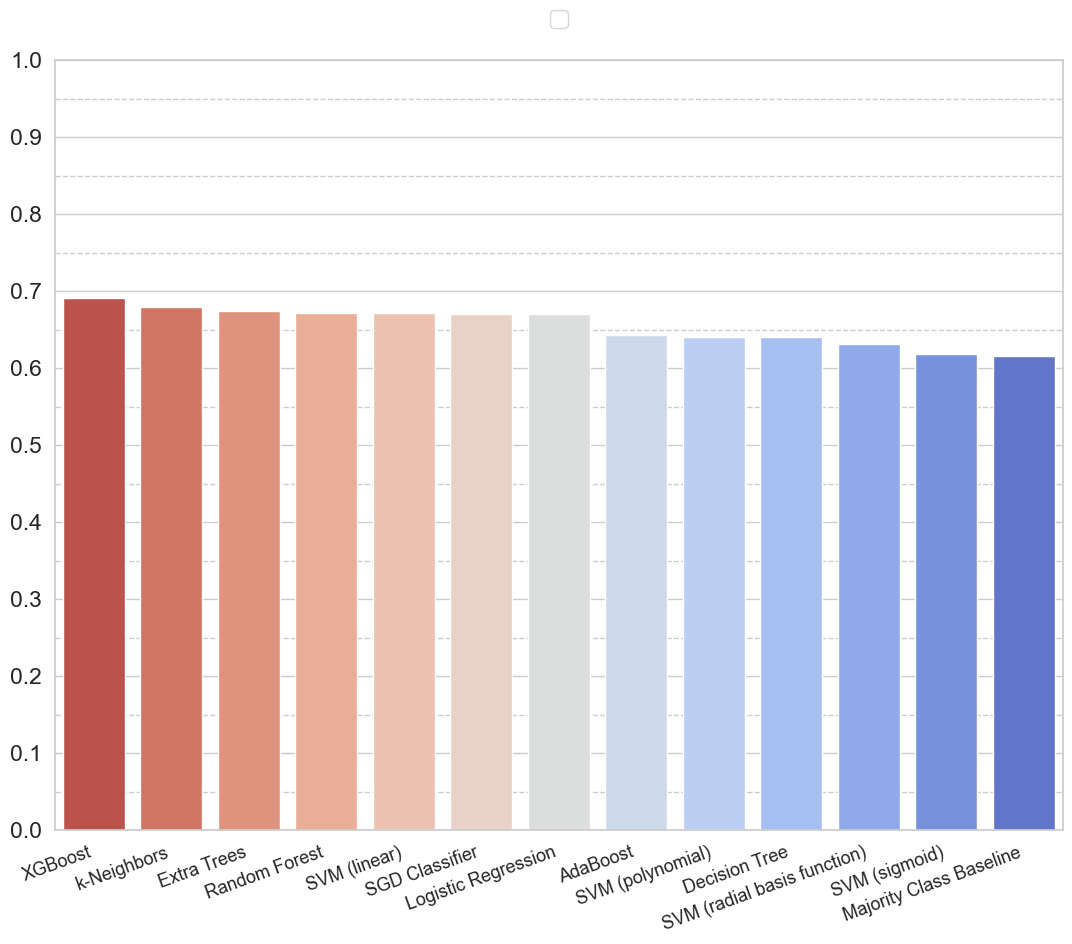

In [20]:
dd = pd.DataFrame(data=results_embeddings,
                  columns = ['classifier','f1'])
pal = 'coolwarm_r'
fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
sns.barplot(x="classifier", y='f1', ci="sd", palette=pal, order=dd.groupby('classifier').mean().sort_values('f1',ascending=False).index.tolist(), data=dd, dodge=True)
plt.ylim(ymax = 1,ymin=0)
plt.legend(ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.08))
#plt.title("recall")
ax.set_yticks(np.arange(0.0, 1.1, 0.1))
ax.set_yticks(np.arange(0.0, 1.05, 0.05),minor=True)
ax.yaxis.grid(which='minor', linestyle='--')
ax.yaxis.grid(which='major', linestyle='-')
plt.xlabel('')
plt.ylabel('')
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=20, ha='right', fontsize=13)
fig.savefig("classifier_embed.png")